#### Данный файл является просто моим обучением по выборке классической модели (без нейросетей) для следующего соревнования на Kaggle: https://www.kaggle.com/competitions/titanic/overview. В нем требуется обучить модель для выявлению статуса пассажиров Титаника (выжил или нет).

In [8]:
import pandas as pd
import numpy as np

In [187]:
train_data = pd.read_csv('train.csv')
train_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


# Columns:
- (int) PassengerId
- (int) Survived
- (int) Pclass (ticket class: 1th, 2nd, 3rd)
- (object) Name
- (object) Sex
- (float) Age
- (int) SibSp (были ли супруг/супруга на корабле)
- (int) Parch (количество родственников на корабле)
- (object) Ticket (number)
- (float) Fare (cost of ticket)
- (object) Cabin (номер каюты)
- (object) Embarked (в каком порту сел на борт: C = Cherbourg, Q = Queenstown, S = Southampton)

In [188]:
train_data['Cabin'] = train_data['Cabin'].fillna(0)
train_data.loc[train_data['Cabin'] != 0, 'Cabin'] = 1
train_data = train_data.dropna()
train_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,0,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,1,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,0,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,1,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,0,S
...,...,...,...,...,...,...,...,...,...,...,...,...
885,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,0,Q
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,0,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,1,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,1,C


In [189]:
num_cols = train_data[train_data.columns[np.array([2, 5, 6, 7, 9, 10])]]
cat_cols = train_data[train_data.columns[np.array([4, 11])]]

train_dummies = pd.get_dummies(cat_cols)

y = train_data['Survived']
X_origin = pd.concat([num_cols, cat_cols], axis=1) # для catboost
X = pd.concat([num_cols, train_dummies], axis=1)
train_data.shape, X_origin.shape, X.shape, y.shape

((712, 12), (712, 8), (712, 11), (712,))

In [151]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, train_size=0.8, random_state=41)
X_train_origin, X_test_origin, _, _ = train_test_split(X_origin.values, y.values, train_size=0.8, random_state=41)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((569, 11), (569,), (143, 11), (143,))

### Для разминки посмотрим, как справятся более слабенькие модели, такие как "случайный лес" и "логистическая регрессия". Я пренебрегу наиболее высокой точностью и поэтому буду использовать параметры, которые больше всего влияют на точность, в GridSearch. Их будет не слишком много, так как не хочется ждать обучения несколько часов.

In [115]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

In [141]:
def f(X, y, model, param_grid):
    if isinstance(model, LogisticRegression):
        # нормируем данные для лог.регрессии, так как присутствуют довольно сильно разнящиеся данные
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
    cv_model = GridSearchCV(estimator=model,
                            param_grid=param_grid,
                            scoring='roc_auc',
                            cv=5,
                            n_jobs=-1,
                            verbose=10)

    cv_model.fit(X, y)
    print('____' + str(type(model)) + '____')
    print(f'best score: {cv_model.best_score_}')
    print(f'best params: {cv_model.best_params_}')

In [142]:
models = [RandomForestClassifier(), LogisticRegression()]
params_grids = [
    {
        'n_estimators': [30, 50, 70, 100, 150],
        'max_depth': [3, 5, 10, 20],
        'criterion': ['gini', 'entropy', 'log_loss'],
        'class_weight': ['balanced', 'balanced_subsample', None],
        'min_samples_split': [0.1, 3, 5, 10],
        'class_weight': [None, 'balanced']
    }, 
    {
        'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
        'C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
        'class_weight': [None, 'balanced'],
        'max_iter': [100, 500, 1000, 2000, 5000]
    }
]

for model, param_grid in zip(models, params_grids):
    f(X_train, y_train, model, param_grid)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits
____<class 'sklearn.ensemble._forest.RandomForestClassifier'>____
best score: 0.8724159817638079
best params: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 150}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits
____<class 'sklearn.linear_model._logistic.LogisticRegression'>____
best score: 0.8550424535207144
best params: {'C': 10, 'class_weight': None, 'max_iter': 100, 'solver': 'liblinear'}


## По метрике roc-auc получаем:
---
#### Random Forest Classifier
Best score: 0.8724

Best parameters:
```py
class_weight=None,
criterion='entropy',
max_depth=20,
min_samples_split=10,
n_estimators=150
```
---
#### Logistic regression
Best score: 0.8550

Best parameters:
```py
C=10,
class_weight=None,
max_iter=100,
solver='liblinear'
```
---

In [ ]:
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier

In [144]:
def g(X, y, model, param_grid):

    cv_model = GridSearchCV(estimator=model,
                            param_grid=param_grid,
                            scoring='roc_auc',
                            cv=5,
                            n_jobs=-1,
                            verbose=10)
    
    cv_model.fit(X, y)

    print('____' + str(type(model)) + '____')
    print(f'best score: {cv_model.best_score_}')
    print(f'best params: {cv_model.best_params_}')

In [148]:
boost_models = [lgb.LGBMClassifier(random_state=42, verbosity=-1),
                xgb.XGBClassifier(random_state=42),
                CatBoostClassifier(random_state=42, cat_features=np.array([6, 7]))]
boost_params_grids = [
    {
        'learning_rate': np.array([0.0001, 0.001, 0.01, 0.1]),
        'n_estimators': np.array([100, 200, 300, 400, 500]),
        'max_depth': np.array([3, 5, 7]),
        'num_leaves': [20, 31, 40, 50]
    },
    {
        'learning_rate': np.array([0.0001, 0.001, 0.01, 0.1]),
        'n_estimators': np.array([100, 200, 300, 400, 500]),
        'max_depth': np.array([3, 5, 7]),
        'tree_method': ['auto', 'exact', 'approx', 'hist']
    },
    {
        'learning_rate': np.array([0.0001, 0.001, 0.01, 0.1]),
        'iterations': np.array([100, 200, 300, 400, 500]),
        'depth': np.array([3, 5, 7])
    }
]

for model, param_grid in zip(boost_models, boost_params_grids):
    if isinstance(model, CatBoostClassifier):
        g(X_train_origin, y_train, model, param_grid)
    else:
        g(X_train, y_train, model, param_grid)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
____<class 'lightgbm.sklearn.LGBMClassifier'>____
best score: 0.8745285672459584
best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 20}
Fitting 5 folds for each of 240 candidates, totalling 1200 fits
____<class 'xgboost.sklearn.XGBClassifier'>____
best score: 0.8726552795031054
best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'tree_method': 'approx'}
Fitting 5 folds for each of 60 candidates, totalling 300 fits
0:	learn: 0.6430319	total: 11.1ms	remaining: 2.21s
1:	learn: 0.6063515	total: 21.9ms	remaining: 2.17s
2:	learn: 0.5730545	total: 37.6ms	remaining: 2.47s
3:	learn: 0.5500967	total: 48.4ms	remaining: 2.37s
4:	learn: 0.5272435	total: 64ms	remaining: 2.5s
5:	learn: 0.5153611	total: 79.4ms	remaining: 2.57s
6:	learn: 0.5035106	total: 94.9ms	remaining: 2.62s
7:	learn: 0.4890863	total: 110ms	remaining: 2.63s
8:	learn: 0.4840880	total: 125ms	remaining: 2.65s
9:	lear

## Получаем следующие результаты:
---
#### LightGBM

Best score: 0.8745

Best params:
```py
learning_rate=0.1
max_depth=3
n_estimators=100
num_leaves=20
```
---
#### XGBoost

Best score: 0.8727

Best params:
```py
learning_rate=0.1
max_depth=3
n_estimators=100
tree_method='approx'
```
---
#### CatBoost

Best score: 0.8750

Best params:
```py
depth=3
iterations=200
learning_rate=0.1
```

---
Интересно, конечно, что градиентный бустинг недалеко ушел от случайного леса...  
Теперь проверим данные на тестовой выборке.

In [171]:
from sklearn.metrics import roc_auc_score, roc_curve

In [181]:
def h(X_train, X_test, y_train, y_test, model):
    model.fit(X_train, y_train)
    y_train_predict = model.predict(X_train)
    y_test_predict = model.predict(X_test)
    
    train_auc = roc_auc_score(y_train, y_train_predict)
    test_auc = roc_auc_score(y_test, y_test_predict)
    
    name_of_model = str(type(model)).split('.')[-1][:-2]
    plt.figure(figsize=(20,10))
    plt.title(name_of_model)
    plt.plot(*roc_curve(y_train, y_train_predict)[:2], label='train AUC={:.4f}'.format(train_auc))
    plt.plot(*roc_curve(y_test, y_test_predict)[:2], label='test AUC={:.4f}'.format(test_auc))
    legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
    legend_box.set_facecolor("white")
    legend_box.set_edgecolor("black")
    plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
    plt.show()

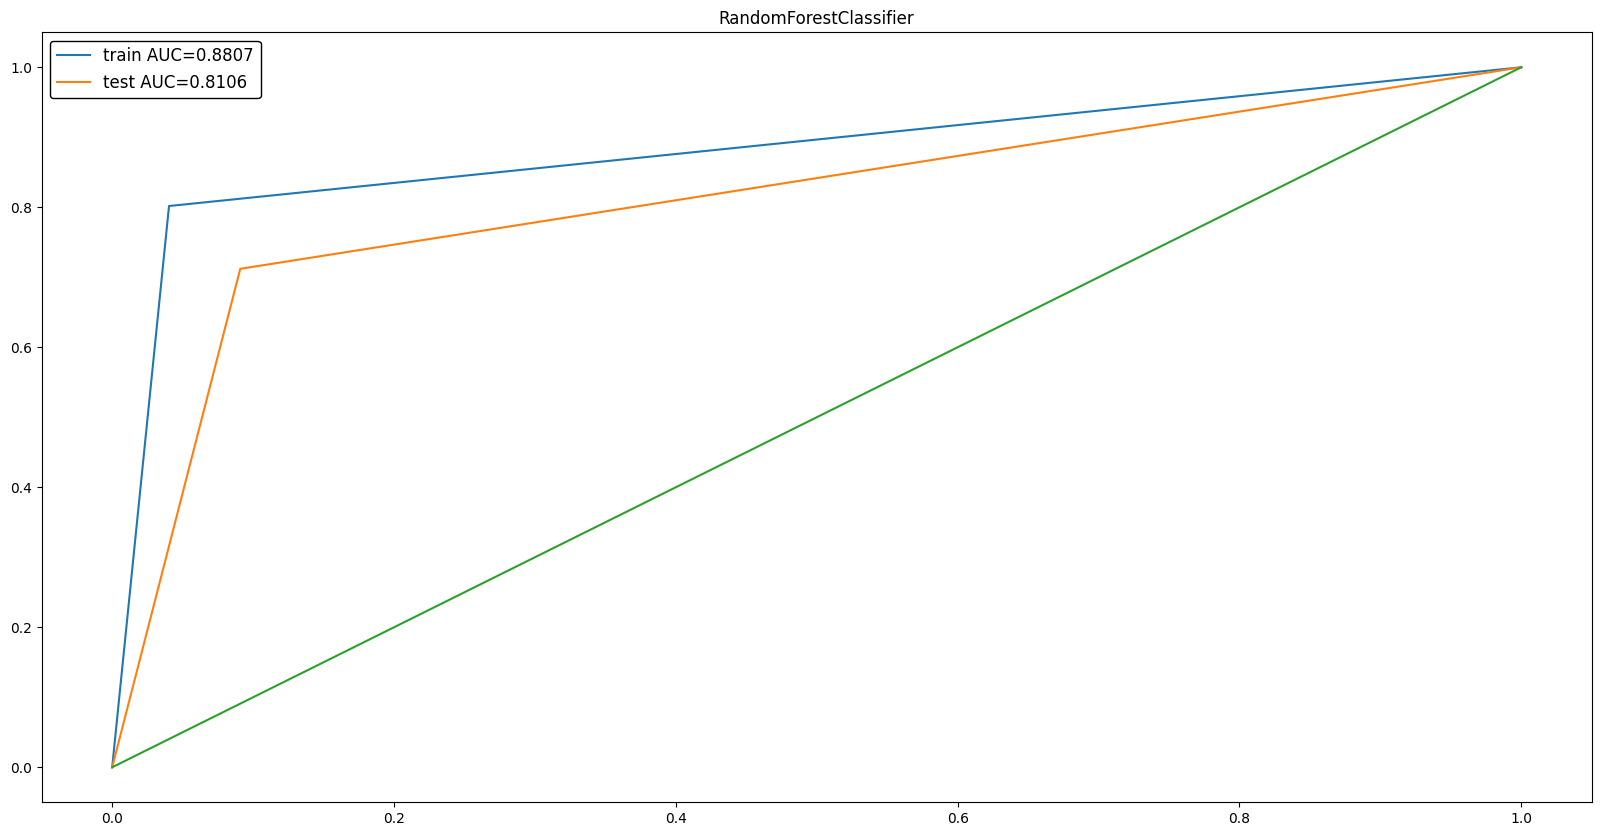

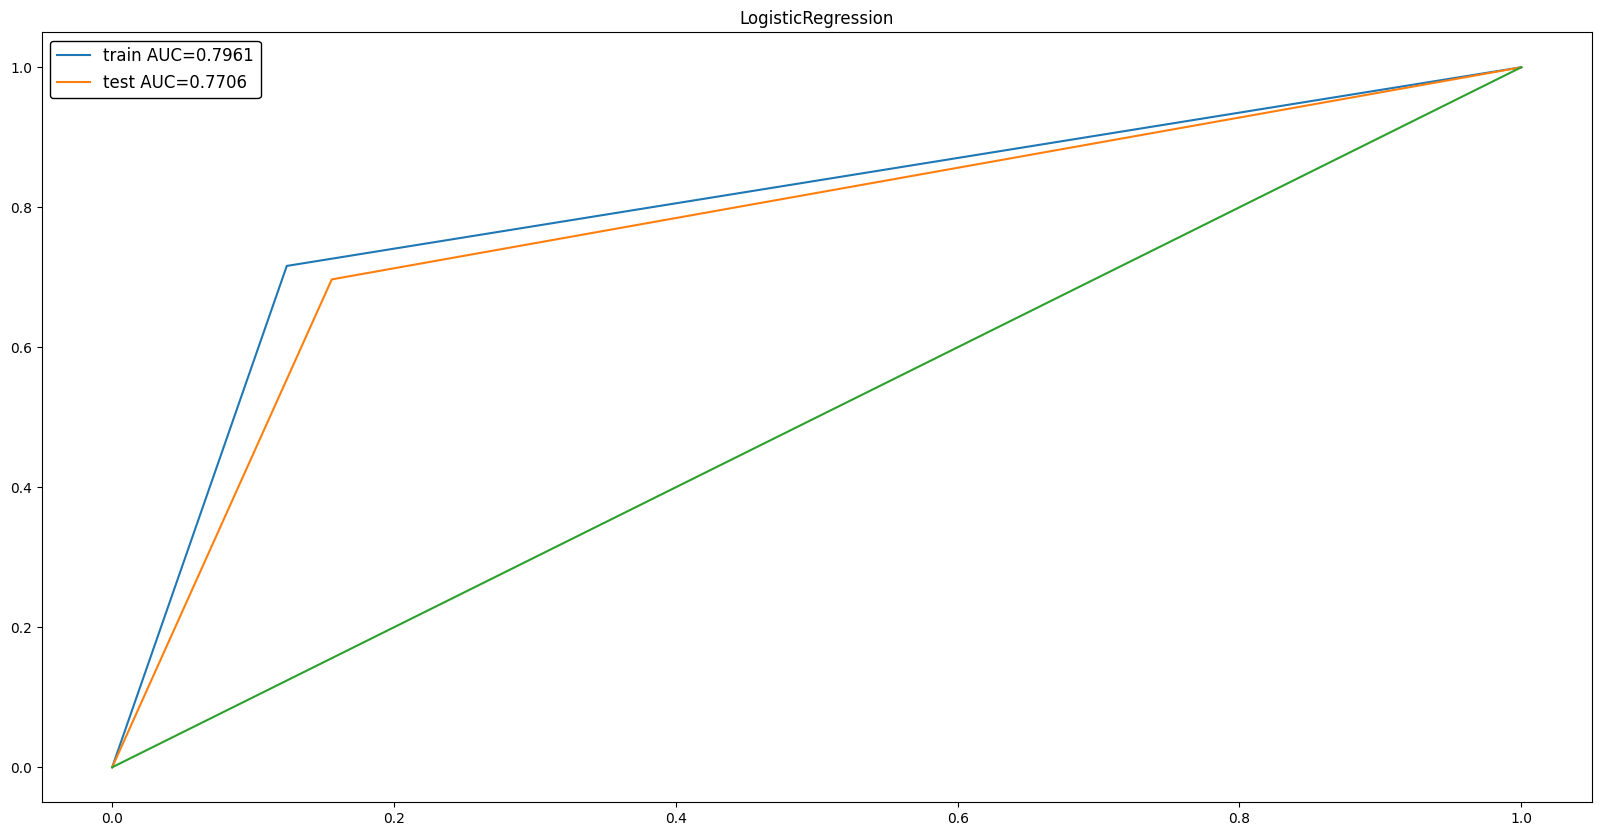

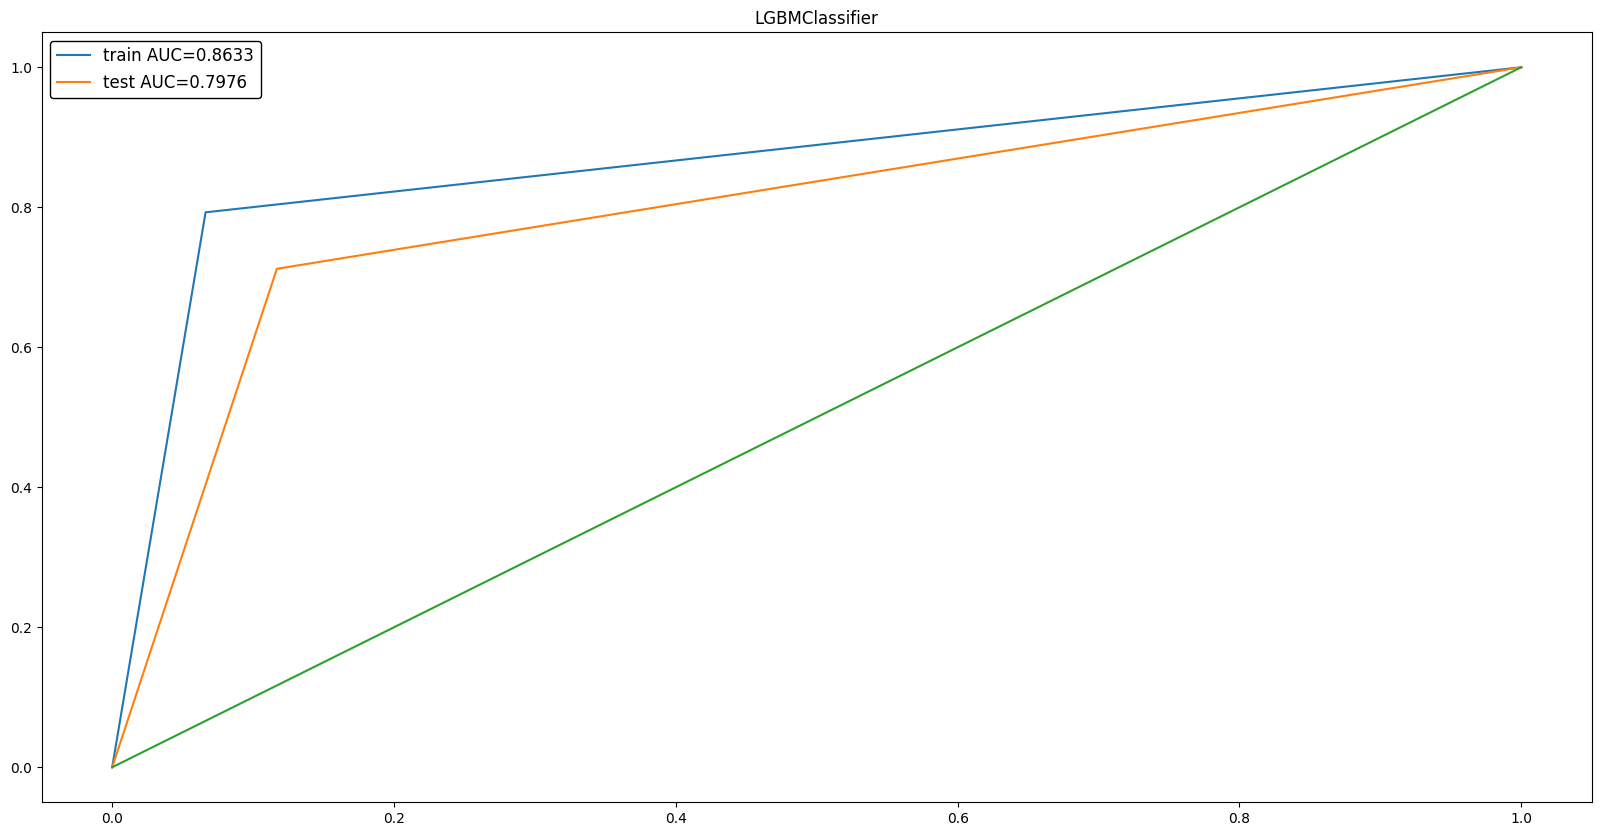

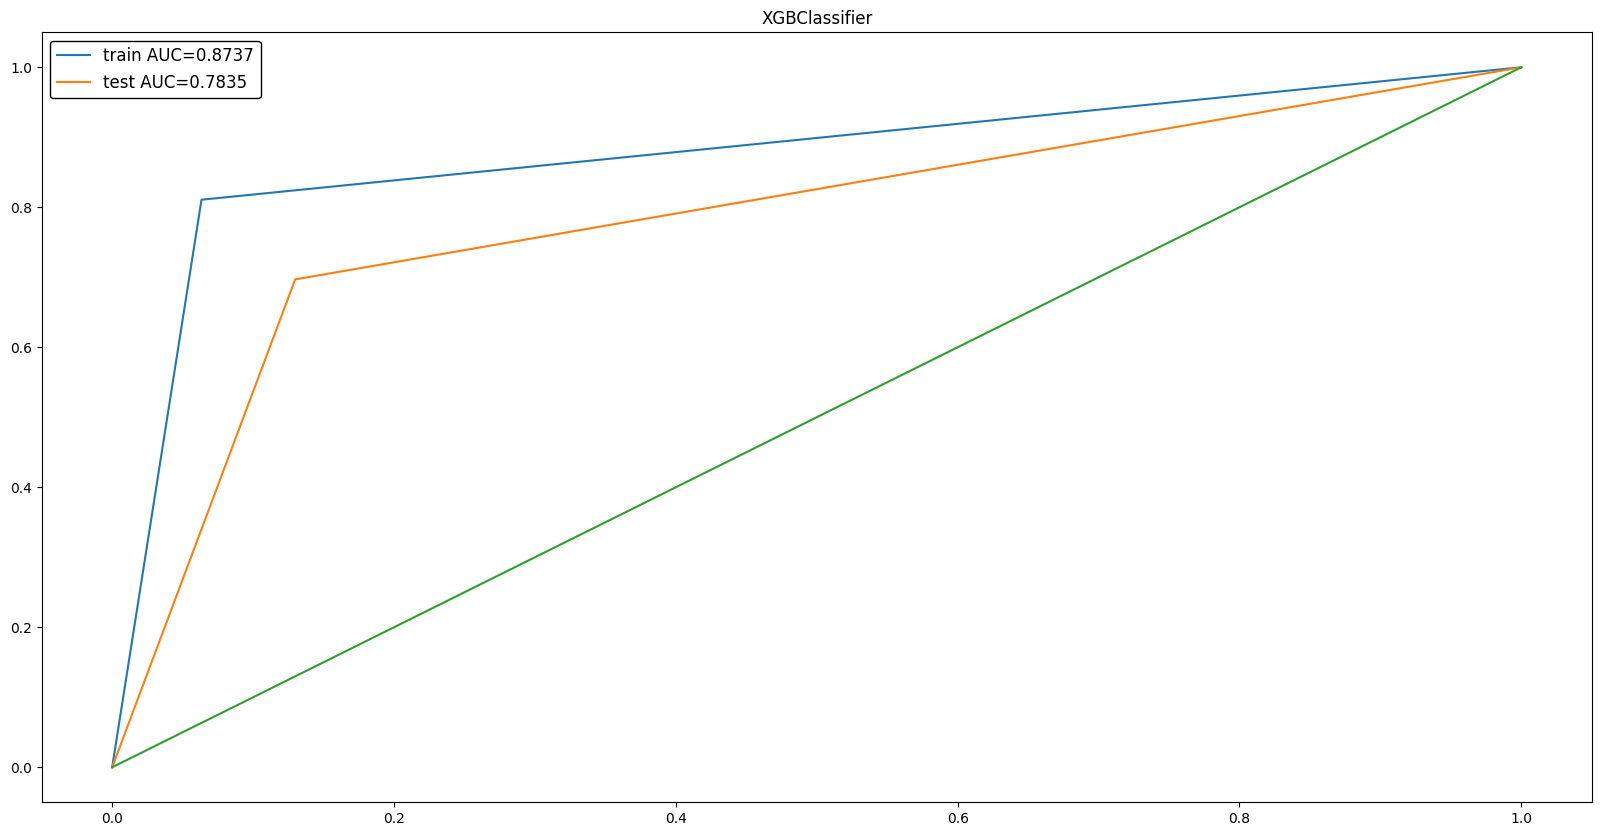

0:	learn: 0.6421690	total: 11.3ms	remaining: 2.25s
1:	learn: 0.5979676	total: 23.1ms	remaining: 2.29s
2:	learn: 0.5702345	total: 38ms	remaining: 2.49s
3:	learn: 0.5404580	total: 52.4ms	remaining: 2.57s
4:	learn: 0.5201464	total: 69.3ms	remaining: 2.7s
5:	learn: 0.5038329	total: 83.9ms	remaining: 2.71s
6:	learn: 0.4881216	total: 94.8ms	remaining: 2.61s
7:	learn: 0.4775001	total: 109ms	remaining: 2.63s
8:	learn: 0.4693931	total: 124ms	remaining: 2.63s
9:	learn: 0.4640793	total: 140ms	remaining: 2.66s
10:	learn: 0.4611014	total: 156ms	remaining: 2.68s
11:	learn: 0.4552916	total: 171ms	remaining: 2.67s
12:	learn: 0.4515047	total: 185ms	remaining: 2.66s
13:	learn: 0.4478456	total: 200ms	remaining: 2.65s
14:	learn: 0.4451043	total: 214ms	remaining: 2.64s
15:	learn: 0.4383929	total: 229ms	remaining: 2.63s
16:	learn: 0.4377086	total: 245ms	remaining: 2.63s
17:	learn: 0.4359612	total: 259ms	remaining: 2.62s
18:	learn: 0.4349903	total: 274ms	remaining: 2.61s
19:	learn: 0.4335249	total: 288ms	rem

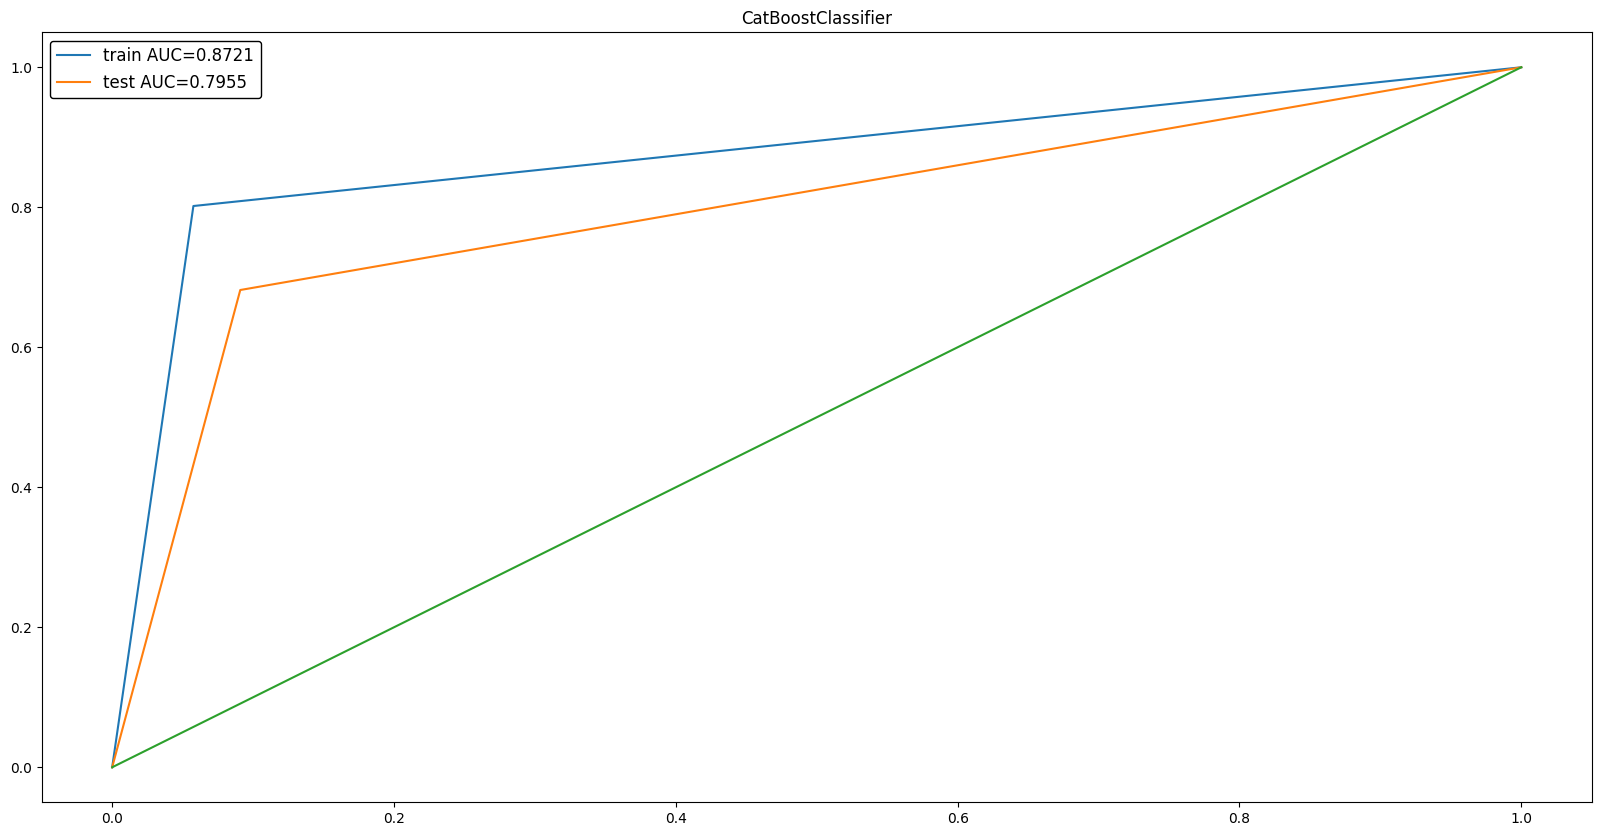

In [182]:
models_for_test = [
    RandomForestClassifier(random_state=41, class_weight=None, criterion='entropy', max_depth=20, min_samples_split=10, n_estimators=150),
    LogisticRegression(random_state=41, C=10, class_weight=None, max_iter=100, solver='liblinear'),
    lgb.LGBMClassifier(random_state=41, verbosity=-1, learning_rate=0.1, max_depth=3, n_estimators=100, num_leaves=20),
    xgb.XGBClassifier(random_state=41, learning_rate=0.1, max_depth=3, n_estimators=100, tree_method='approx'),
    CatBoostClassifier(random_state=41, cat_features=np.array([6, 7]), depth=3, iterations=200, learning_rate=0.1)
]

for model in models_for_test:
    if isinstance(model, CatBoostClassifier):
        h(X_train_origin, X_test_origin, y_train, y_test, model)
    else:
        h(X_train, X_test, y_train, y_test, model)

# Итог

Внезапно, но получилось так, что случайный лес предсказывает результат точнее, чем градиентный бустинг. Возможно, второй мог переобучиться, однако на тренировочной выборке случайный лес не сильно отставал. Значит, данный результат, скорее всего, получился из-за специфики данных, по которым даже интуитивно сложно дать верный ответ, но утверждать это не буду, потому что не исключаю ошибку по своей неопытности.  
Следующий блок предназначен для подготовки ответов на отправку для соревнования на Kaggle.  
P.S. Score на Kaggle = 0.77990 (думаю, что для первого раза вполне неплохо, почти 80% точности).

In [194]:
test_data = pd.read_csv('test.csv')
test_data['Cabin'] = test_data['Cabin'].fillna(0)
test_data.loc[test_data['Cabin'] != 0, 'Cabin'] = 1

# среднее значение возраста пассажиров = 30.272590361445783
# test_data.dropna()
# mean_age = test_data['Age'].mean()
# mean_age

test_data['Age'] = test_data['Age'].fillna(30)

test_num_cols = test_data[test_data.columns[np.array([1, 4, 5, 6, 8, 9])]]
test_cat_cols = test_data[test_data.columns[np.array([3, 10])]]

test_dummies = pd.get_dummies(test_cat_cols)

XX = pd.concat([test_num_cols, test_dummies], axis=1)

final_model = RandomForestClassifier(random_state=41, class_weight=None, criterion='entropy', max_depth=20, min_samples_split=10, n_estimators=150)

final_model.fit(X, y)

y_predict = final_model.predict(XX)
y_predict.shape

(418,)

In [201]:
ans = pd.read_csv('gender_submission.csv')
ans['Survived'] = np.array(y_predict)
ans.to_csv('gender_submission.csv', index=False)
ans.head(35)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0
